# Finding the perfect Restaurants on Yelp
- credits https://www.kaggle.com/code/niyamatalmass/finding-the-perfect-restaurants-on-yelp/notebook
- Dataset: This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the dataset, you'll find information about businesses across 11 metropolitan areas in four countries.
- deep dive into the Yelp datasets and find meaningful information about restaurants

In [32]:
## Libraries
## if ModuleNotFoundError: No module named 'wordcloud'
## do conda install -c conda-forge wordcloud
## or pip install wordcloud
## pip install textblob

import gc # garbage collector
import numpy as np # linear algebra
from collections import Counter # for counting commong words
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
plt.style.use('fivethirtyeight') # use ggplot ploting style
import seaborn as sns # visualization 
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
from textblob import TextBlob
# import ploty for visualization
import plotly
import plotly.offline as py # make offline 
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.tools as tls
import plotly.figure_factory as fig_fact

#plotly.tools.set_config_file(world_readable=True, sharing='public')
# remove war
import warnings
warnings.filterwarnings('ignore')
# this will allow ploting inside the notebook
%matplotlib inline

In [33]:
df_yelp_business = pd.read_csv('data/yelp_business.csv')

In [34]:
df_yelp_business.head(5)

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  stars  review_count  is_open  \
0  33.330690 -111.978599    4.0            22        1   
1  40.291685  -80.104900    3.0            11        1   
2  33.524903 -112.115310    1.5            18        1   
3  33.383147 -111.964725    3.0             9        0   
4  41.119535  -81.475690    3.5           116        1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

In [36]:
#df_yelp_business.neighborhood.unique()

In [39]:
df_yelp_business.stars.max(), df_yelp_business.stars.min()

(5.0, 1.0)

In [41]:
#df_yelp_business.categories.unique()

In [42]:
# categories column has many categories at once. Let's split the categories column 
# and store each category in it's own column
df_category_split = df_yelp_business['categories'].str.split(';', expand=True)[[0,1,2]]
# rename the new columns
df_category_split.columns = ['category_1', 'category_2', 'category_3']
df_yelp_business = pd.concat([df_yelp_business, df_category_split], axis=1)
# now drop the actual categories column
df_yelp_business = df_yelp_business.drop(['categories'], axis=1)
# print the head of the dataset
df_yelp_business.head()

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  stars  review_count  is_open  \
0  33.330690 -111.978599    4.0            22        1   
1  40.291685  -80.104900    3.0            11        1   
2  33.524903 -112.115310    1.5            18        1   
3  33.383147 -111.964725    3.0             9        0   
4  41.119535  -81.475690    3.5           116        1   

                      category_1                    category_2  \
0                       Dentists             General Dentistry   
1                  Hair Stylists                   Hair Salons   
2  Departments of Motor Vehicles  Public Services & Government   
3                 Sporting Goods                      Shopping   
4                 American (New)                     Nightlife   

          category_3  
0   Health & Medical  
1  Men's Hair Salons  
2               None  
3               None  
4               Bars

## Find nearby Restaurants on map
- make a map where each restaurant on Yelp will show. The user can zoom or move the cursor to find their desire restaurants. When the mouse hovers in each restaurants icon a text will pop up and show the restaurant's name and it's rating on Yelp. Let's see!

In [43]:
# let's filter our dataset.
# we'll use Restaurants category
df_yelp_business_restaurants = df_yelp_business.loc[(df_yelp_business['category_1'] == 'Restaurants') | (df_yelp_business['category_2'] == 'Restaurants') | (df_yelp_business['category_3'] == 'Restaurants')]

In [44]:
# take only name and stars for map hover description
fff = df_yelp_business_restaurants[['name', 'stars']].astype(str).apply(lambda x: '. Rating: '.join(x), axis=1).tolist()

In [6]:
# mapbox access token. Go to Mapbox.com and sign up and get your access_token. Don't use mine please. 
mapbox_access_token = 'pk.eyJ1IjoiYWxtYXNzbml5YW1hdCIsImEiOiJjamQ3NGY2Zms0emhmMnFuMjJ5OGNvOWoxIn0.DKGZcDRHVFRYNiQBe1D_zw'

# difine our data for ploting on mapbox
data = Data([
    Scattermapbox(
        lat=df_yelp_business_restaurants.latitude.tolist(),
        lon=df_yelp_business_restaurants.longitude.tolist(),
        mode='markers',
        # add 'bar' as a marker icon. so it's look beautiful 
        marker=Marker(
            symbol='bar',
            size=9
        ),
        text=fff,
    )
])

# dfine our map layout
layout = Layout(
    # add title
    title='Zoom to your location and find your desire restaurants',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        # add our access token
        accesstoken=mapbox_access_token,
        bearing=0,
        # add center location to our map
        center=dict(
            lat=39.4440302947,
            lon=-98.9565517008
        ),
        # use style light
        style='light',
        pitch=0,
        # zoom label to 3
        zoom=3
    ),
)

# let's make the final figure
fig = dict(data=data, layout=layout)
# finally plot the map
py.iplot(fig, filename='Multiple Mapbox')

## Top rated restaurants
- Yelp is a collection of different business in different areas. In Yelp the most popular business is Restaurants business. Yelp has a huge collection of restaurants. It's quite impossible to plot that thousands of business ratings. So I take top 20 most occurrences restaurants and calculate their mean of stars review's polarity and plot them and see which is most popular restaurants.

In [45]:
# import yelp_review.csv file
# this dataset contains all of the business customer reviews and their date
df_yelp_review = pd.read_csv('data/yelp_review.csv', nrows=100000)
# import yelp_tip.csv file. 
# this dataset contains user tips for business.
#df_yelp_tip = pd.read_csv('../input/yelp_tip.csv')
df_yelp_review.head(5)

review_id                 user_id             business_id  \
0  vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw  AEx2SYEUJmTxVVB18LlCwA   
1  n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw  VR6GpWIda3SfvPC-lg9H3w   
2  MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw  CKC0-MOWMqoeWf6s-szl8g   
3  IXvOzsEMYtiJI0CARmj77Q  bv2nCi5Qv5vroFiqKGopiw  ACFtxLv8pGrrxMm6EgjreA   
4  L_9BTb55X0GDtThi6GlZ6w  bv2nCi5Qv5vroFiqKGopiw  s2I_Ni76bjJNK9yG60iD-Q   

   stars        date                                               text  \
0      5  2016-05-28  Super simple place but amazing nonetheless. It...   
1      5  2016-05-28  Small unassuming place that changes their menu...   
2      5  2016-05-28  Lester's is located in a beautiful neighborhoo...   
3      4  2016-05-28  Love coming here. Yes the place always needs t...   
4      4  2016-05-28  Had their chocolate almond croissant and it wa...   

   useful  funny  cool  
0       0      0     0  
1       0      0     0  
2       0      0     0  
3       0      0     0  
4       0      0     0

In [46]:
# import yelp_tip.csv file. 
# this dataset contains user tips for business.
df_yelp_tip = pd.read_csv('data/yelp_tip.csv')
df_yelp_tip.head(3)

text        date  likes  \
0  Great breakfast large portions and friendly wa...  2015-08-12      0   
1  Nice place. Great staff.  A fixture in the tow...  2014-06-20      0   
2                     Happy hour 5-7 Monday - Friday  2016-10-12      0   

              business_id                 user_id  
0  jH19V2I9fIslnNhDzPmdkA  ZcLKXikTHYOnYt5VYRO5sg  
1  dAa0hB2yrnHzVmsCkN4YvQ  oaYhjqBbh18ZhU0bpyzSuw  
2  dAa0hB2yrnHzVmsCkN4YvQ  ulQ8Nyj7jCUR8M83SUMoRQ

In [47]:
df_yelp_review.head(2)

review_id                 user_id             business_id  \
0  vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw  AEx2SYEUJmTxVVB18LlCwA   
1  n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw  VR6GpWIda3SfvPC-lg9H3w   

   stars        date                                               text  \
0      5  2016-05-28  Super simple place but amazing nonetheless. It...   
1      5  2016-05-28  Small unassuming place that changes their menu...   

   useful  funny  cool  
0       0      0     0  
1       0      0     0

In [48]:
df_yelp_business.head(2)

business_id                   name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg     "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ  "Stephen Szabo Salon"          NaN   

                      address       city state postal_code   latitude  \
0  "4855 E Warner Rd, Ste B9"  Ahwatukee    AZ       85044  33.330690   
1        "3101 Washington Rd"   McMurray    PA       15317  40.291685   

    longitude  stars  review_count  is_open     category_1         category_2  \
0 -111.978599    4.0            22        1       Dentists  General Dentistry   
1  -80.104900    3.0            11        1  Hair Stylists        Hair Salons   

          category_3  
0   Health & Medical  
1  Men's Hair Salons

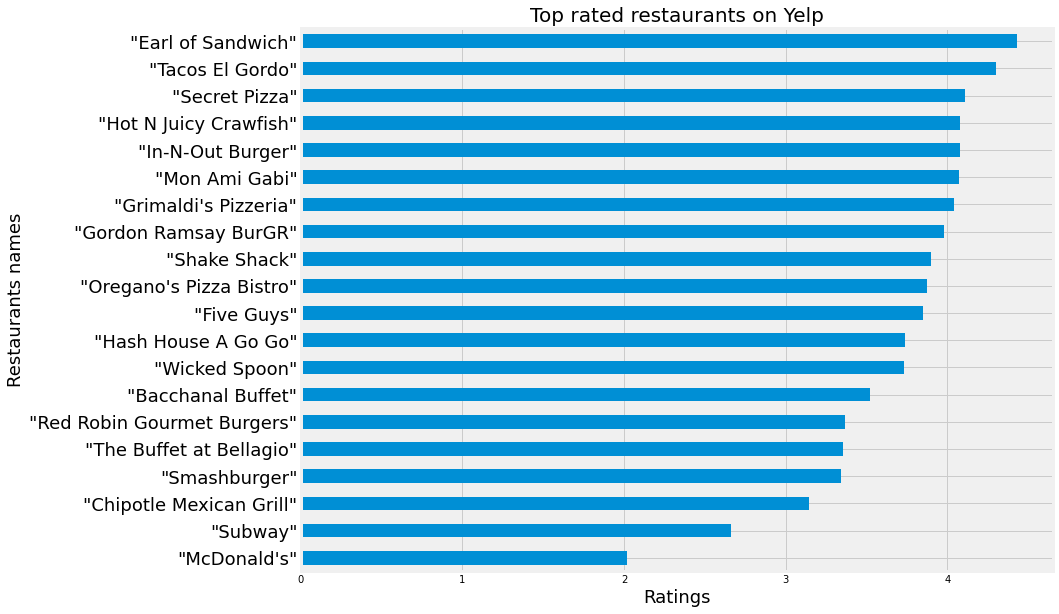

In [9]:
# df_yelp_review dataset has business id but don't have businesss name.
# But df_yelp_business_restaurants have business name and business id.
# So I take the df_yelp_review business_id and match with df_yelp_business_restaurants business id.
# And take the business name from df_yelp_business_restaurants and create a new column in df_yelp_review that holds business name
df_yelp_review['name'] = df_yelp_review['business_id'].map(df_yelp_business_restaurants.set_index('business_id')['name'])
# take the top only 20 most occurances restaurants for analysis. Because the dataset has over thousand business id. It will be really inefficient if we take all of the business name
top_restaurants = df_yelp_review.name.value_counts().index[:20].tolist()
# create a new dataframe called 'df_review_top' that only contains the reviews of 'top_restaurants'
df_review_top = df_yelp_review.loc[df_yelp_review['name'].isin(top_restaurants)]
# now we take the name column and count mean of stars of each unique business name (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then sort values in ascending order 
# then plot the graph

df_review_top.groupby(df_review_top.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10))
# set y ticks font size to 18 for easy readable purposes.
plt.yticks(fontsize=18)
# set the title of the graph
plt.title('Top rated restaurants on Yelp',fontsize=20)
# set y label of the graph and change fontsize to 18 for readablity purposes. 
plt.ylabel('Restaurants names', fontsize=18)
# set x label to 'Ratings'
plt.xlabel('Ratings', fontsize=18)
# now finally show the graph in a new window. 
plt.show()

## IMPORTANT On STOPWORDS
- https://stackoverflow.com/questions/41610543/corpora-stopwords-not-found-when-import-nltk-library
- python -m nltk.downloader stopwords


In [10]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again
# let's find out which stopwords need to remove. We'll use english stopwords.
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j)
df_review_top['text_clear'] = df_review_top['text'].apply(preprocess)

def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

df_review_top['senti_polarity'] = df_review_top['text_clear'].apply(sentiment)

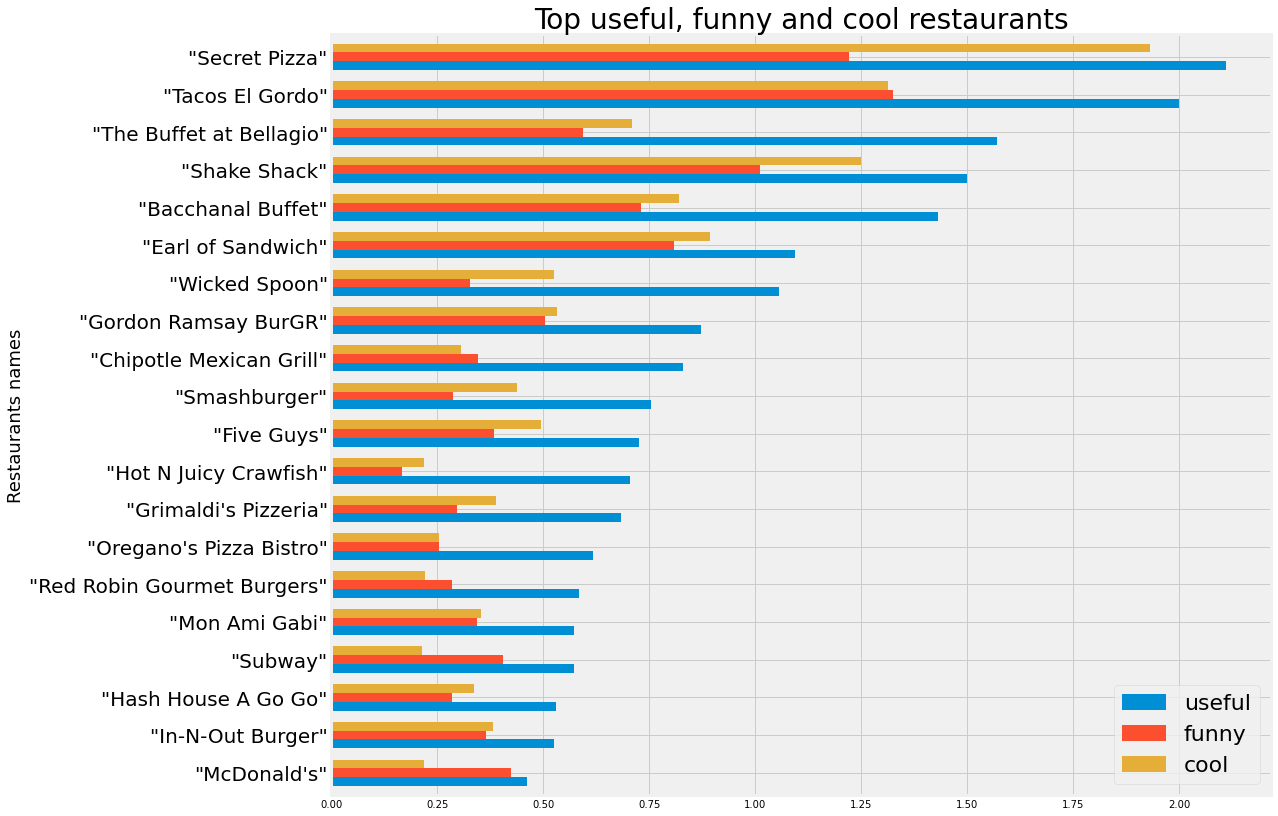

In [11]:
# now we take the name column and count mean of 'useful','funny', 'cool' of each unique business name (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then sort values in ascending order 
# then plot the graph
df_review_top.groupby(df_review_top.name)[['useful','funny', 'cool']].mean().sort_values('useful',ascending=True).plot(kind='barh', figsize=(15, 14),width=0.7)
# set y ticks font size to 18 for easy readable purposes.
plt.yticks(fontsize=18)
# set the title of the graph
plt.title('Top useful, funny and cool restaurants',fontsize=28)
# set y label of the graph and change fontsize to 18 for readablity purposes.
plt.ylabel('Restaurants names', fontsize=18)
# set the y ticks
plt.yticks(fontsize=20)
plt.legend(fontsize=22)
# finally show the plot
plt.show()

In [12]:
# function for pre-processing the text of reviews
# this function remove punctuation and stopwords
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again
# let's find out which stopwords need to remove. We'll use english stopwords.
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j)

# df_yelp_tip dataset has business id but don't have businesss name.
# But df_yelp_business_restaurants have business name and business id.
# So I take the df_yelp_tip business_id and match with df_yelp_business_restaurants business id.
# And take the business name from df_yelp_business_restaurants and create a new column in df_yelp_tip that holds business name
df_yelp_tip['name'] = df_yelp_tip['business_id'].map(df_yelp_business_restaurants.set_index('business_id')['name'])
# create a new dataframe called 'df_yelp_tip_top' that only contains the reviews of 'top_restaurants'

df_yelp_tip_top = df_yelp_tip.loc[df_yelp_tip['name'].isin(top_restaurants)]
# pre process the text
df_yelp_tip_top['text_clear'] = df_yelp_tip_top['text'].apply(preprocess)

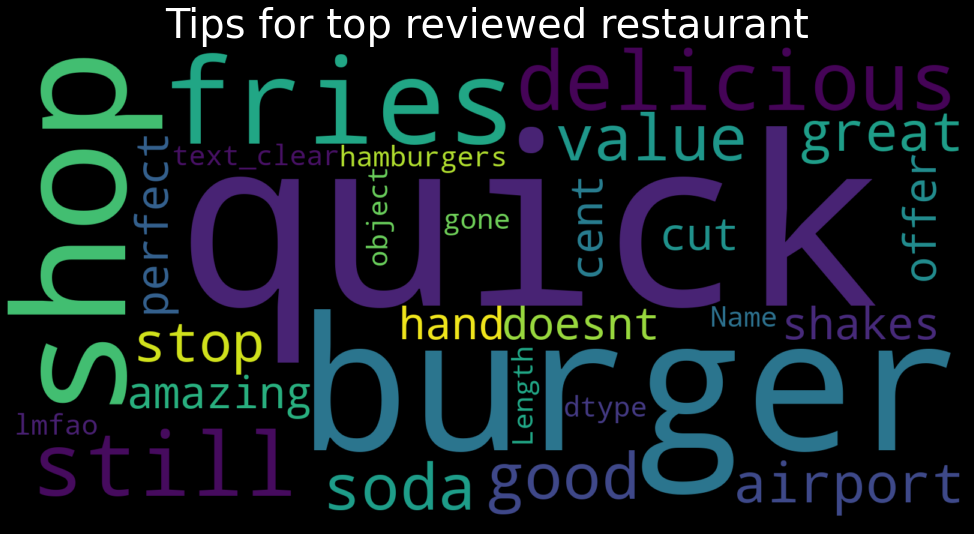

In [13]:
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud using df_yelp_tip_top['text_clear']
wc.generate(str(df_yelp_tip_top['text_clear']))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.title("Tips for top reviewed restaurant", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of congiguration finally plot the graph
plt.show()

## Analyze some of the popular restaurants
- Yelp has a lot of popular restaurants. Let's analyse some of the popular restaurants. In this section, we'll see each restaurant's reviews word cloud, sentiment analysis of reviews ,mean stars in different years, usefulness and others qualities of some random popular restaurants.

### Earl of Sandwich
- is a noble title in the Peerage of England, nominally associated with Sandwich, Kent. It was created in 1660 for the prominent naval commander Admiral Sir Edward Montagu. In this section, I will be analyzing 'Earl of Sandwitch' restaurants data.

In [14]:
# filter Earl of Sandwitch
df_earl_of_sandwitch_only = df_yelp_business_restaurants.loc[df_yelp_business_restaurants['name'] == '"Earl of Sandwich"']
# filter reviews for only Earl of Sandwich
df_earl_of_sandwitch_review = df_yelp_review.loc[df_yelp_review['business_id'].isin(df_earl_of_sandwitch_only.business_id)]

# clear the text
df_earl_of_sandwitch_review['text_clear'] = df_earl_of_sandwitch_review['text'].apply(preprocess)

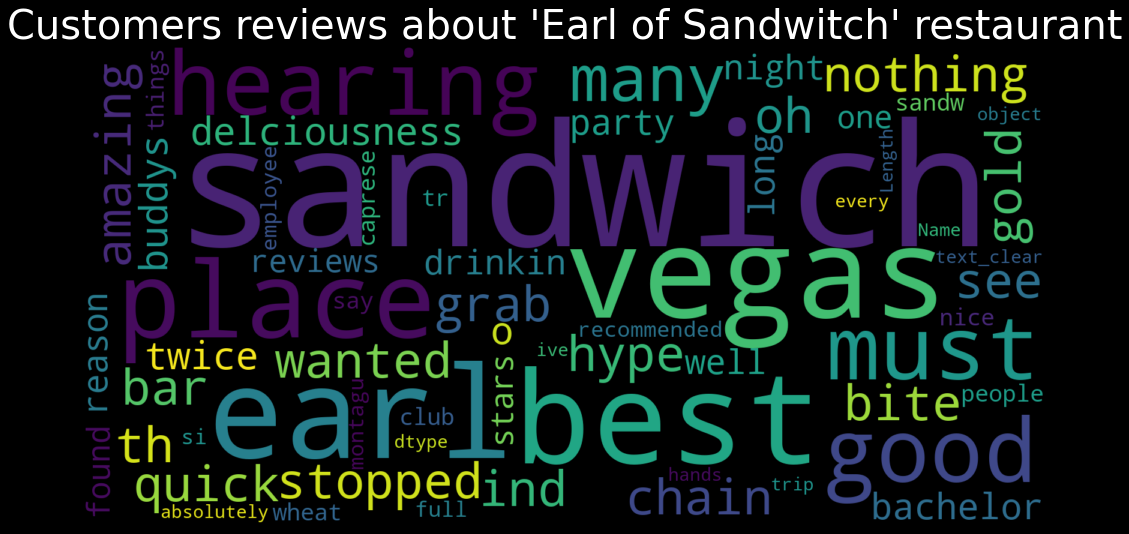

In [15]:
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud
wc.generate(str(df_earl_of_sandwitch_review['text_clear']))
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.title("Customers reviews about 'Earl of Sandwitch' restaurant", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# after lot of configuration finally plot the graph
plt.show()


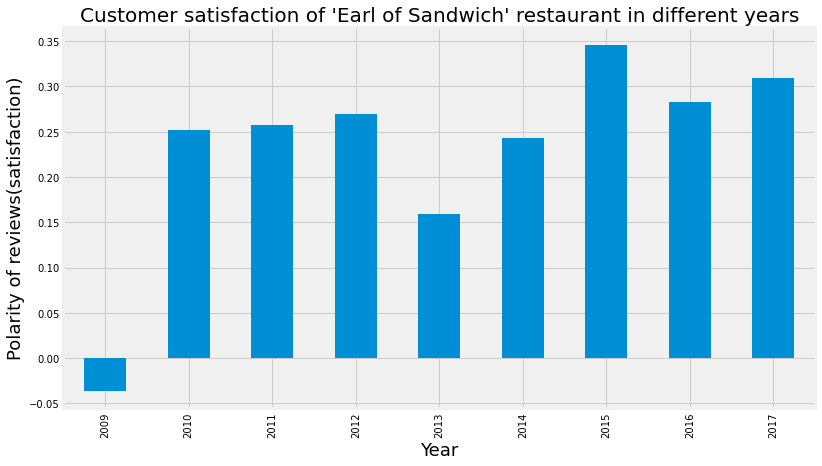

In [16]:
df_earl_of_sandwitch_review['senti_polarity'] = df_earl_of_sandwitch_review['text_clear'].apply(sentiment)
# convert date column to pandas datatime 
df_earl_of_sandwitch_review.date = pd.to_datetime(df_earl_of_sandwitch_review.date)
# now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_earl_of_sandwitch_review.groupby(df_earl_of_sandwitch_review.date.dt.year)['senti_polarity'].mean().plot(kind='bar', figsize=(12, 7))
# set the title of graph
plt.title("Customer satisfaction of 'Earl of Sandwich' restaurant in different years", fontsize=20)
# set xlabel
plt.xlabel('Year', fontsize=18)
# set ylabel
plt.ylabel('Polarity of reviews(satisfaction)', fontsize=18)
# finally show the plot
plt.show()

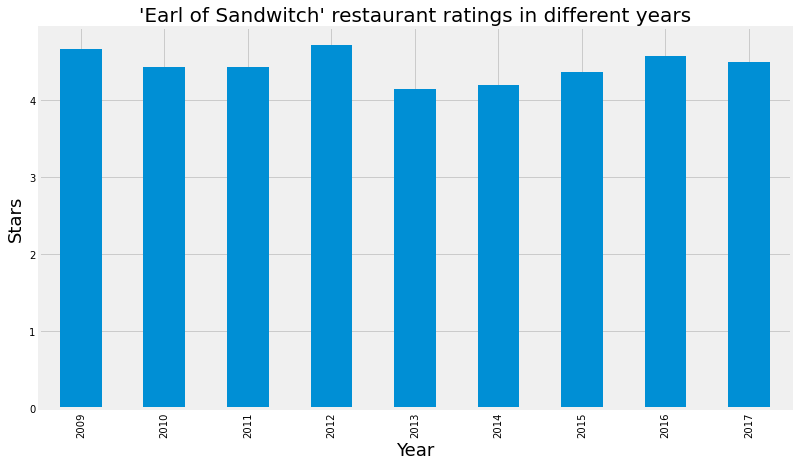

In [17]:
# convert date column to pandas datatime 
df_earl_of_sandwitch_review.date = pd.to_datetime(df_earl_of_sandwitch_review.date)
# now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_earl_of_sandwitch_review.groupby(df_earl_of_sandwitch_review.date.dt.year)['stars'].mean().plot(kind='bar', figsize=(12, 7))
# set the title of graph
plt.title("'Earl of Sandwitch' restaurant ratings in different years", fontsize=20)
# set xlabel
plt.xlabel('Year', fontsize=18)
# set ylabel
plt.ylabel('Stars', fontsize=18)
# finally show the plot
plt.show()

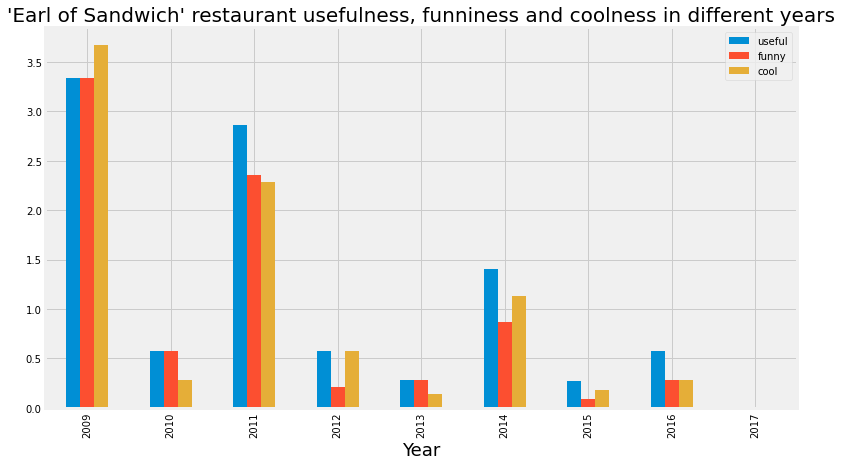

In [18]:
# convert date column to pandas datatime 
df_earl_of_sandwitch_review.date = pd.to_datetime(df_earl_of_sandwitch_review.date)
# now we take the date column as base and count mean of 'useful','funny','cool' of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_earl_of_sandwitch_review.groupby(df_earl_of_sandwitch_review.date.dt.year)[['useful','funny','cool']].mean().plot(kind='bar', figsize=(12, 7))
# set the title of graph
plt.title("'Earl of Sandwich' restaurant usefulness, funniness and coolness in different years", fontsize=20)
# add xlabel
plt.xlabel('Year', fontsize=18)
# finally show the plot
plt.show()

In [19]:
# the dataframe is huge. So we delete the dataframe that we don't need now. 
del df_category_split,df_earl_of_sandwitch_only,df_earl_of_sandwitch_review,df_yelp_business
# let's garbage collector collect garbage
gc.collect()

28929

## Analyze McDonald's reviews
- McDonald's is a fast food company that was founded in 1940 as a restaurant operated by Richard and Maurice McDonald, in San Bernardino, California, United States. They rechristened their business as a hamburger stand. In this section, I will analyze McDonald's customer's reviews on Yelp!

In [20]:
# filter mcdonalds
df_mcdonalds_only = df_yelp_business_restaurants.loc[df_yelp_business_restaurants['name'] == '"McDonald\'s"']
# filter reviews for only McDonalds
df_mcdonalds_review = df_yelp_review.loc[df_yelp_review['business_id'].isin(df_mcdonalds_only.business_id)]
# pre process the text
df_mcdonalds_review['text_clear'] = df_mcdonalds_review['text'].apply(preprocess)

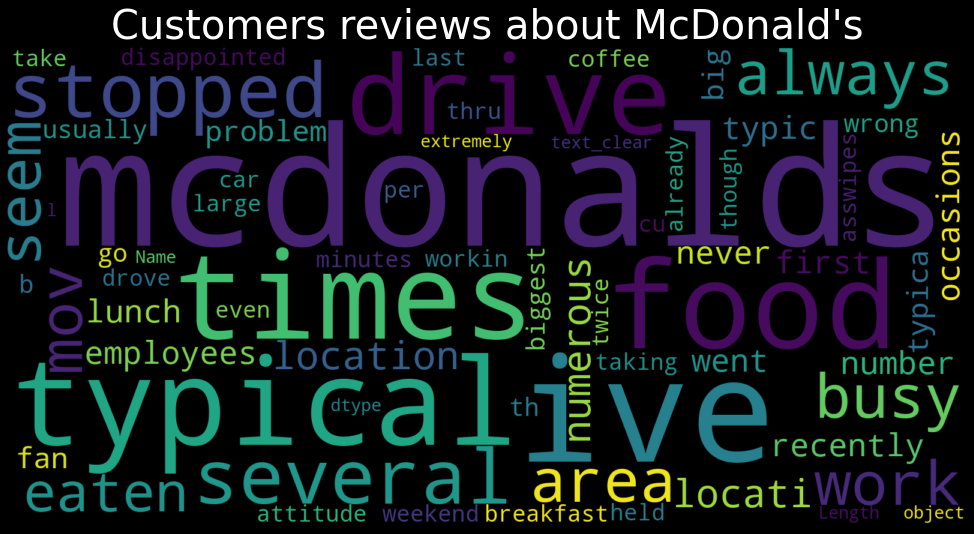

In [21]:
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud
wc.generate(str(df_mcdonalds_review['text_clear']))
# figure of graph
plt.figure(figsize=(20,10), facecolor='k')
# add the title to the graph
plt.title("Customers reviews about McDonald's", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# finally show the plot
plt.show()

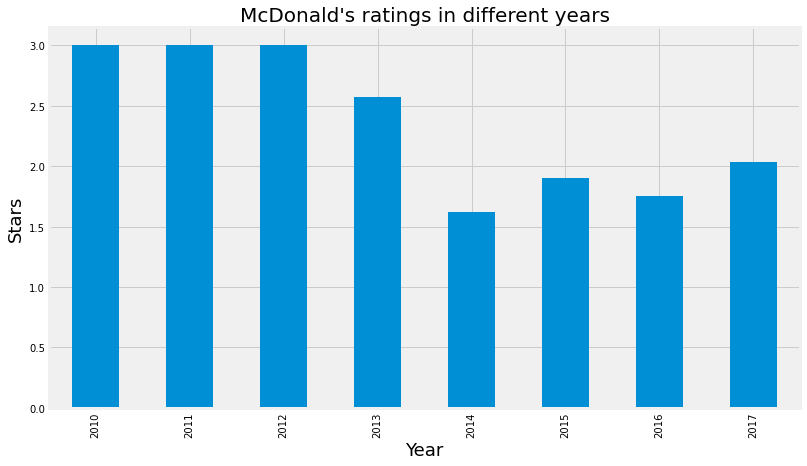

In [22]:
# convert data column to pandas datetime
df_mcdonalds_review.date = pd.to_datetime(df_mcdonalds_review.date)
# now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_mcdonalds_review.groupby(df_mcdonalds_review.date.dt.year)['stars'].mean().plot(kind='bar', figsize=(12, 7))
# add the title of plot
plt.title("McDonald's ratings in different years", fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Stars', fontsize=18)
# finally plot the graph
plt.show()

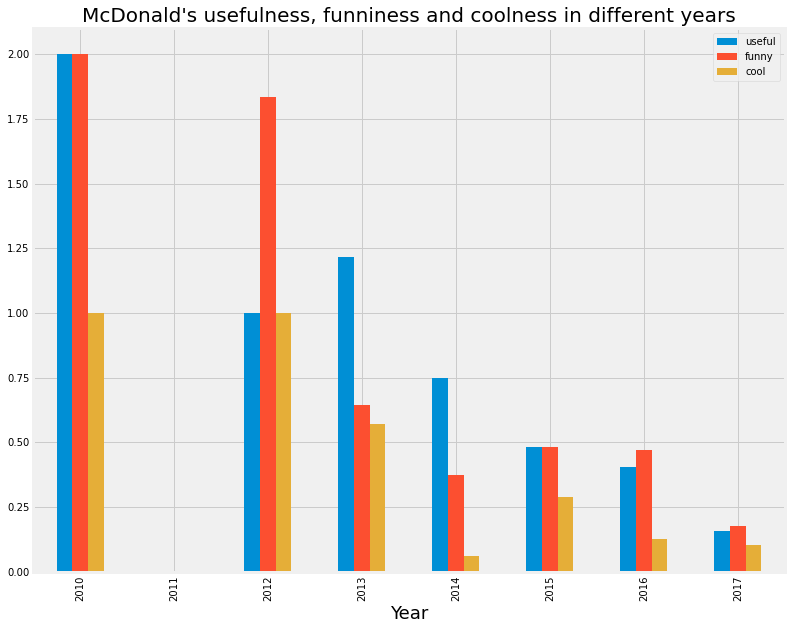

In [23]:
# convert data column to pandas datetime
df_mcdonalds_review.date = pd.to_datetime(df_mcdonalds_review.date)
# now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_mcdonalds_review.groupby(df_mcdonalds_review.date.dt.year)[['useful','funny','cool']].mean().plot(kind='bar', figsize=(12, 10))
# add the title of plot
plt.title("McDonald's usefulness, funniness and coolness in different years", fontsize=20)
plt.xlabel('Year', fontsize=18)
# finally plot the graph
plt.show()

In [24]:
# delete what we don't need anymore
del df_mcdonalds_only,df_mcdonalds_review
gc.collect()


10518

##  Analyze Subway's restaurant reviews
- Subway is a privately held American fast food restaurant franchise that primarily purveys submarine sandwiches and salads. In this section, I will analyze McDonald's customer's reviews on Yelp!

In [25]:
# filter mcdonalds
df_subway_only = df_yelp_business_restaurants.loc[df_yelp_business_restaurants['name'] == '"Subway"']
# filter reviews for only Subways
df_subway_review = df_yelp_review.loc[df_yelp_review['business_id'].isin(df_subway_only.business_id)]

In [26]:
# preprocess the text
df_subway_review['text_clear'] = df_subway_review['text'].apply(preprocess)

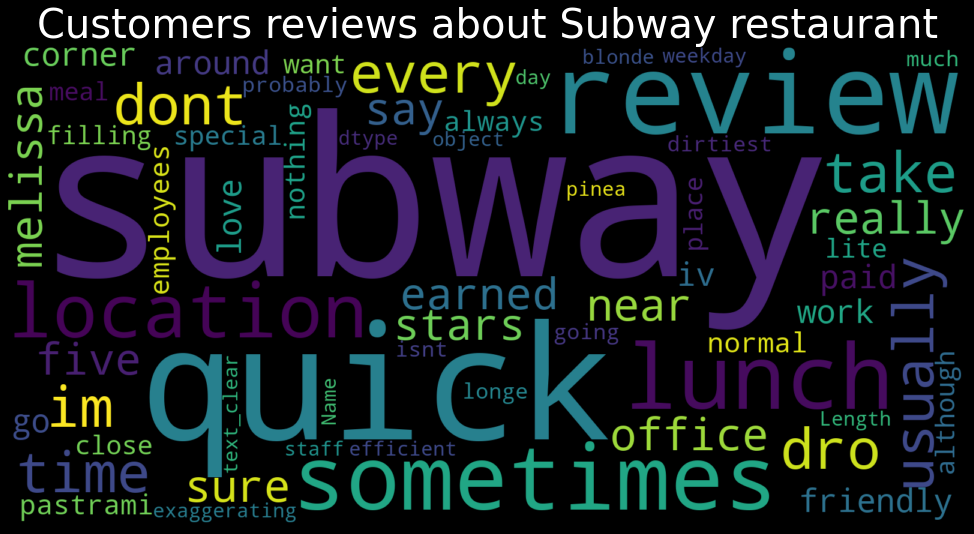

In [27]:
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud
wc.generate(str(df_subway_review['text_clear']))
plt.figure(figsize=(20,10), facecolor='k')
# title of the graph
plt.title("Customers reviews about Subway restaurant", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# finally show the word cloud
plt.show()

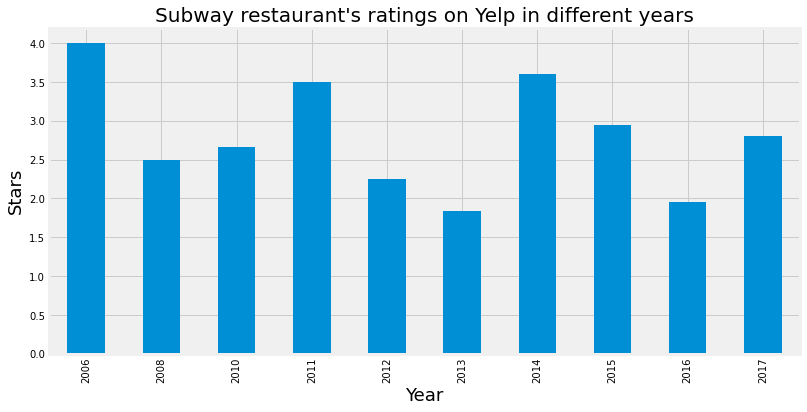

In [28]:
# convert date column to pandas datetime
df_subway_review.date = pd.to_datetime(df_subway_review.date)
# now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_subway_review.groupby(df_subway_review.date.dt.year)['stars'].mean().plot(kind='bar', figsize=(12, 6))
# add the title 
plt.title("Subway restaurant's ratings on Yelp in different years", fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Stars', fontsize=18)
# finally show the plot
plt.show()

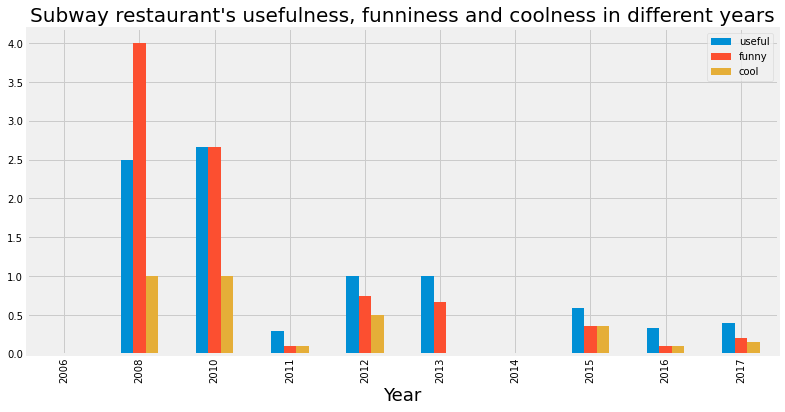

In [29]:
# convert date column to pandas datetime
df_subway_review.date = pd.to_datetime(df_subway_review.date)
# now we take the date column as base and count mean of 'useful','funny','cool' of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
# then plot the graph
df_subway_review.groupby(df_subway_review.date.dt.year)[['useful','funny','cool']].mean().plot(kind='bar', figsize=(12, 6))
# add the title
plt.title("Subway restaurant's usefulness, funniness and coolness in different years", fontsize=20)
plt.xlabel('Year', fontsize=18)
# finally show the plot
plt.show()

In [30]:
# delete what we don't need anymore.
del df_subway_only,df_subway_review, df_review_top,df_yelp_business_restaurants,df_yelp_review
gc.collect()

11160